In [10]:
import pandas as pd
import openpyxl
hotelsdata = pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/hotels.xlsx").set_index('hotel')
hotelsdata


,Unnamed: 0,rooms,price
hotel,,,
hotel_1,0,13,273
hotel_2,1,18,92
hotel_3,2,12,141
hotel_4,3,18,157
hotel_5,4,7,298
...,...,...,...
hotel_396,395,5,212
hotel_397,396,12,68
hotel_398,397,14,102


In [2]:
print(5)

5


In [11]:
guestdata = pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/guests.xlsx").set_index('guest')
guestdata

,Unnamed: 0,discount
guest,,
guest_1,0,0.09
guest_2,1,0.00
guest_3,2,0.07
guest_4,3,0.00
guest_5,4,0.10
...,...,...
guest_3996,3995,0.00
guest_3997,3996,0.15
guest_3998,3997,0.07


In [12]:
preferencesdata=pd.read_excel(r"/Users/menimalina/Desktop/uni_due/coding/python/python-project/hotels/preferences.xlsx").set_index(['guest','hotel'])
preferencesdata

Unnamed: 0  priority
guest      hotel                          
guest_1    hotel_168           0         1
           hotel_207           1         2
           hotel_222           2         3
           hotel_124           3         4
           hotel_223           4         5
...                          ...       ...
guest_4000 hotel_123       99528        28
           hotel_396       99529        29
           hotel_161       99530        30
           hotel_330       99531        31
           hotel_290       99532        32

[99533 rows x 2 columns]

In [13]:
import numpy as np

In [10]:
preferencesdata.describe()

,Unnamed: 0,priority
count,99533.000000,99533.000000
mean,49766.000000,17.011102
std,28732.846509,11.688444
min,0.000000,1.000000
25%,24883.000000,7.000000
50%,49766.000000,15.000000
75%,74649.000000,25.000000
max,99532.000000,49.000000


In [10]:
guestdata.describe()

,Unnamed: 0,discount
count,4000.000000,4000.000000
mean,1999.500000,0.093948
std,1154.844867,0.058057
min,0.000000,0.000000
25%,999.750000,0.040000
50%,1999.500000,0.100000
75%,2999.250000,0.140000
max,3999.000000,0.190000


In [11]:
hotelsdata.describe()

,Unnamed: 0,rooms,price
count,400.000000,400.000000,400.000000
mean,199.500000,11.542500,177.645000
std,115.614301,4.387633,73.159379
min,0.000000,5.000000,50.000000
25%,99.750000,8.000000,116.750000
50%,199.500000,11.000000,183.000000
75%,299.250000,15.000000,238.250000
max,399.000000,19.000000,299.000000


In [12]:
allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction', 'paid_price'])

In [5]:
preferencesdata.value_counts(subset=['guest','hotel'])

guest       hotel    
guest_2018  hotel_383    5
guest_436   hotel_334    4
guest_1250  hotel_205    4
guest_3072  hotel_294    3
guest_3006  hotel_216    3
                        ..
guest_2199  hotel_385    1
            hotel_374    1
            hotel_357    1
            hotel_339    1
guest_999   hotel_43     1
Name: count, Length: 95778, dtype: int64

In [7]:
preferencesdata.drop_duplicates(['guest','hotel'])

KeyError: Index(['hotel', 'guest'], dtype='object')

In [15]:
def calculate_satisfaction_percentage(guest_id, hotel_id, preferencesdata):
    guest_preferences = preferencesdata[preferencesdata.index == guest_id].reset_index()


    if guest_preferences.empty:
        # No preferences, so 100% satisfaction
        return 100

    is_hotel_one_of_preferred = hotel_id in guest_preferences['hotel'].values

    if is_hotel_one_of_preferred:
        index_of_preference = guest_preferences['hotel'].eq(hotel_id).idxmax()
        guest_preferences_count = len(guest_preferences)
        return round(((guest_preferences_count - index_of_preference) / guest_preferences_count) * 100)
    else:
        # Guest settled for a not preferred hotel, so 0% satisfaction
        return 0

In [6]:
import matplotlib.pyplot as plt

def visualize_allocation(allocation):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot 1: Paid price sum for each hotel
    paid_price_by_hotel = allocation.groupby('hotel_id')['paid_price'].sum()
    paid_price_by_hotel.plot(kind='bar', ax=ax1, title='Paid Price Sum by Hotel')
    ax1.set_xlabel('Hotel ID')
    ax1.set_ylabel('Paid Price Sum')

    # Plot 2: Satisfaction percentage for each guest
    satisfaction_by_guest = allocation.groupby('guest_id')['satisfaction_percentage'].mean()
    satisfaction_by_guest.plot(kind='bar', ax=ax2, title='Satisfaction Percentage by Guest')
    ax2.set_xlabel('Guest ID')
    ax2.set_ylabel('Satisfaction Percentage')

    fig.suptitle(f"number of customers/rooms = {str(len(allocation))}; number of hotels = {str(allocation['hotel_id'].nunique())}")

    plt.tight_layout()
    plt.show()

Start calculate random allocation


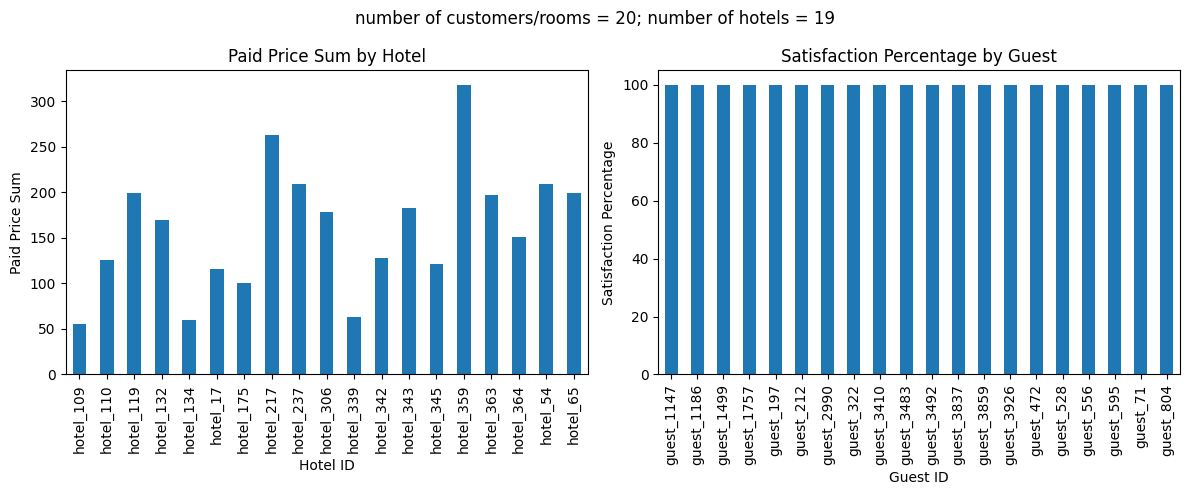

In [16]:
def allocate_random_hotel(guest_id, guest_row, hotelsdata, preferencesdata):
    available_hotels = hotelsdata[hotelsdata['rooms'] > 0]
    if available_hotels.empty:
        return None

    # randomly picking the hotel
    random_available_hotel_id = random.choice(available_hotels.index)
    # returning the row (aka the room)
    random_available_hotel_row = available_hotels.loc[random_available_hotel_id]
    # excluding the room from table of available rooms
    random_available_hotel_row['rooms'] -= 1

    paid_price_coefficient = 1 - guest_row['discount']
    paid_price = random_available_hotel_row['price'] * paid_price_coefficient

    satisfaction = calculate_satisfaction_percentage(guest_id, random_available_hotel_id, preferencesdata)

    return [guest_id, random_available_hotel_id, satisfaction, paid_price]

def get_random_allocation(hotelsdata, guestdata, preferencesdata):
    allocation = pd.DataFrame(columns=['guest_id', 'hotel_id', 'satisfaction_percentage', 'paid_price'])

    # randomizing guests
    shuffled_guests = guestdata.sample(frac=1, random_state=42)
    # we're taking every guest_id AND every pair guest_id|discount
    for guest_id, guest_row in shuffled_guests.iterrows():
        allocation_entry = allocate_random_hotel(guest_id, guest_row, hotelsdata, preferencesdata)
        if allocation_entry is not None:
            allocation.loc[len(allocation)] = allocation_entry

    return allocation

print('Start calculate random allocation')
random_allocation = get_random_allocation(hotelsdata.copy(), guestdata, preferencesdata)
visualize_allocation(random_allocation.head(20))

In [8]:
import pandas as pd
import random